# Modèle LASSO linéaire (fonction de coût $\ell_2$ et pénalité $\ell_1$)

## Théorie

### Fondamentaux

La régression LASSO (Least Absolute Shrinkage and Selection Operator) est une technique de régularisation qui ajoute une pénalité L1 aux coefficients du modèle. 

Cette méthode présente deux avantages majeurs : elle permet une sélection automatique des variables en réduisant certains coefficients exactement à zéro, tout en limitant le sur-apprentissage grâce à la pénalisation des coefficients élevés.

Contrairement à la régularisation Ridge (L2) qui ne fait que réduire l'amplitude des coefficients, le LASSO peut éliminer des variables du modèle. C'est pourqoui on l'utilise pour nos modèle de régression linéaire parcimonieux.

Pour ce faire, on résout ce problème de minimisation :

$$ \boxed{\min_{\beta\in\mathbb{R}^p}\|y-X\beta\|_2^2+\lambda\|\beta\|_1}$$

avec une pénalité $\|\beta\|_1=\sum_{j=1}^p|\beta_j|$

### Choix du $\lambda$

On utilise ici l'algorithme détaillé dans OUTILS/QUT.ipynb spécifique à LASSO en connaissant le paramètre de bruit (oracle)

### Optimisation

Pour résoudre ce problème de minisation on peut utiliser dans notre cas 2 méthodes ISTA et CD (Coordinate descent) qui sont expliqué en profondeur dans les notebooks présent dans le dossier OUTILS.

#### ISTA

On se ramène à un problème à résoudre de cette forme :  
$$\min_{\beta\in\mathbb{R}^p} F(\beta) := f(\beta) + g(\beta)$$

avec

- $f(\beta) = \|y - X\beta\|_2^2$ :  
    Il s'agit du terme d'erreur quadratique (moindre carrés) (MSE).  
    $f$ est une fonction convexe, différentiable, à gradient lipschitzien.

- $g(\beta) = \lambda \|\beta\|_1$ :  
    Il s'agit du terme de pénalisation $\ell_1$. 
    $g$ est convexe, non différentiable, mais proximable.

On peut ainsi très bien utiliser ISTA pour résoudre ce problème.

Le gradient de la fonction $f$ se calcule comme suit :

$$
\nabla f(\beta) = -2 X^\top (y - X\beta)
$$

##### Constante L


Par définition,  $L$ est tel que :
$$\|\nabla f(a) - \nabla f(b)\|_2 \leq L \|a - b\|_2, \quad \forall a, b \in \mathbb{R}^p$$

Or, 
$$\nabla f(\beta) = -2 X^\top (y - X\beta)$$

Donc 
$$\|\nabla f(a) - \nabla f(b)\|_2 = \left\| 2 X^\top X (a - b) \right\|_2 \leq \left\| 2 X^\top X \right\|_2 \|a - b\|_2$$

Ainsi, 
$$L = \left\| 2 X^\top X \right\|_2 = 2 \|X\|_2^2$$

##### Proximal de g

Dans notre cas, le proximal du terme de pénalisation $\ell_1$ avec un pas $\gamma = 1/L$ s'écrit :

$$
\text{prox}_{\frac{\lambda}{L} \|\cdot\|_1}(z) = \arg\min_{x \in \mathbb{R}^p} \left\{ \frac{L}{2} \|x - z\|_2^2 + \lambda \|x\|_1 \right\}
$$

Ce proximal correspond toujours à l'opérateur de seuillage doux:

$$
\text{prox}_{\frac{\lambda}{L} \|\cdot\|_1}(z) = \operatorname{sign}(z) \odot \max\left(|z| - \frac{\lambda}{L},\, 0\right)
$$

où $\odot$ désigne le produit terme à terme (Hadamard) entre les vecteurs.

#### Coordinate descent

Comme pour ISTA, on se ramène à un problème de la forme suivante :

$$\min_\beta h(\beta) := f(\beta) + \lambda \Omega(\beta),$$

où dans notre cas :

- $f : \mathbb{R}^p \to \mathbb{R} = \|y - X\beta\|_2^2$
- $\Omega : \mathbb{R}^p \to \mathbb{R}$ est la fonction de pénalisation, non lisse mais séparable :
    - $\Omega(\beta) = \sum_{j=1}^p \Omega_j(\beta_j)$ avec $\Omega_j : \mathbb{R} \to \mathbb{R} = |\beta_j|$.
- $\lambda > 0$ est le paramètre de régularisation.

##### Constante L

C'est la même que pour ista

En coordinate descent pour le LASSO, chaque coordonnée $j$ possède sa propre constante de Lipschitz $L_j$ pour le gradient par rapport à $\beta_j$. 

Formellement, pour $f(\beta) = \|y - X\beta\|_2^2$, on a :

$$
L_j = 2 \|X_{:,j}\|_2^2
$$

où $X_{:,j}$ désigne la $j$-ème colonne de $X$.

##### Proximal de $\Omega$

Le proximal de $\Omega$ pour la pénalité $\ell_1$ (coordinatewise) s'écrit :

$$
\operatorname{prox}_{\tau |\cdot|}(v_j) = \operatorname{sign}(v_j) \cdot \max\left(|v_j| - \tau,\, 0\right)
$$

où $\tau = \lambda / L_j$ et $v_j$ est la $j$-ème coordonnée.  
Ceci correspond à l'opérateur de seuillage doux (soft-thresholding).


## Simulations

In [7]:
import sys, pathlib
sys.path.append(str(pathlib.Path.cwd().parent.parent.parent.parent)+"\AYMEN\EXPLORATION\CAS LINEAIRE\OUTILS")

In [8]:
n = 70
p = 250
list_s = [20]
#list_s = range(0, 31)

sigma = 0.1

simu_iter=10
qut_iter=1000
max_iter=10000
tol=1e-6

seed=43

### LASSO avec Cordinate Descent en ORACLE

|20| Simulations pour s = 20 :
	 |1| Simulation 1/10 :
		 beta : [3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
		 beta estimé : [ 0.544  1.144  1.355  1.947  3.403  3.76   2.82   1.8    1.391  2.696  1.92   2.741  1.83   2.919  2.357  2.521  1.693
  1.461  1.706  1.109  0.015  0.    -0.0

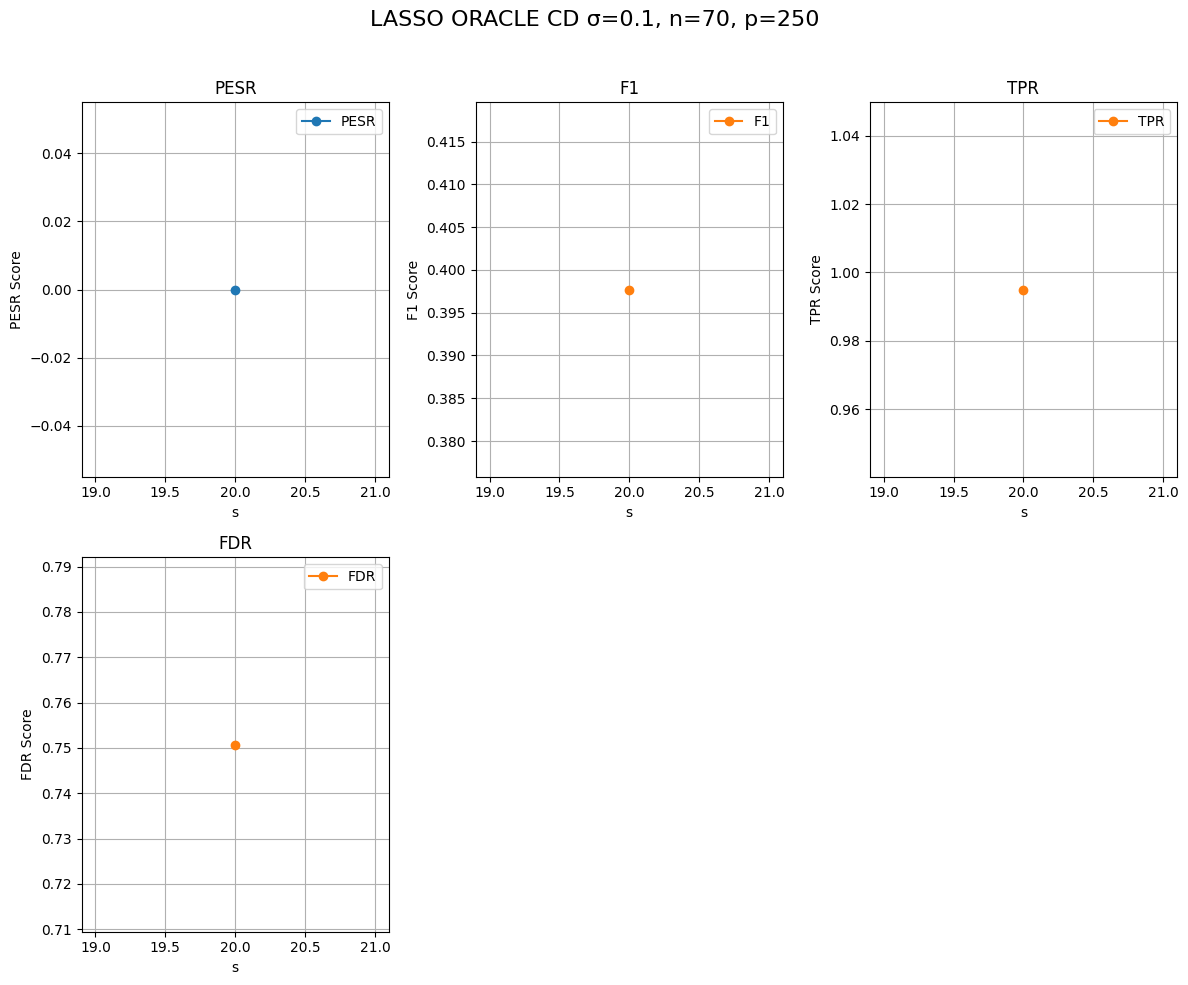

In [9]:
from simulations import SimulationLassoOracleCd

Sim3 = SimulationLassoOracleCd(
    n = n,
    p = p,
    list_s = list_s,
    sigma = sigma,
    simu_iter = simu_iter,
    qut_iter = qut_iter,
    max_iter = max_iter,
    tol = tol*1e-10,
    seed = seed,
    verbose=True
)

Sim3.run()

Sim3.plot()

### LASSO avec ISTA en ORACLE

|20| Simulations pour s = 20 :
	 |1| Simulation 1/10 :
		 beta : [3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
		 beta estimé : [ 0.415  0.579  0.     0.     3.068  4.228  2.224  1.485  1.994  1.724  1.111  2.219  1.076  2.811  2.323  1.036  0.932
  0.334  0.     1.329  0.431  0.    -0. 

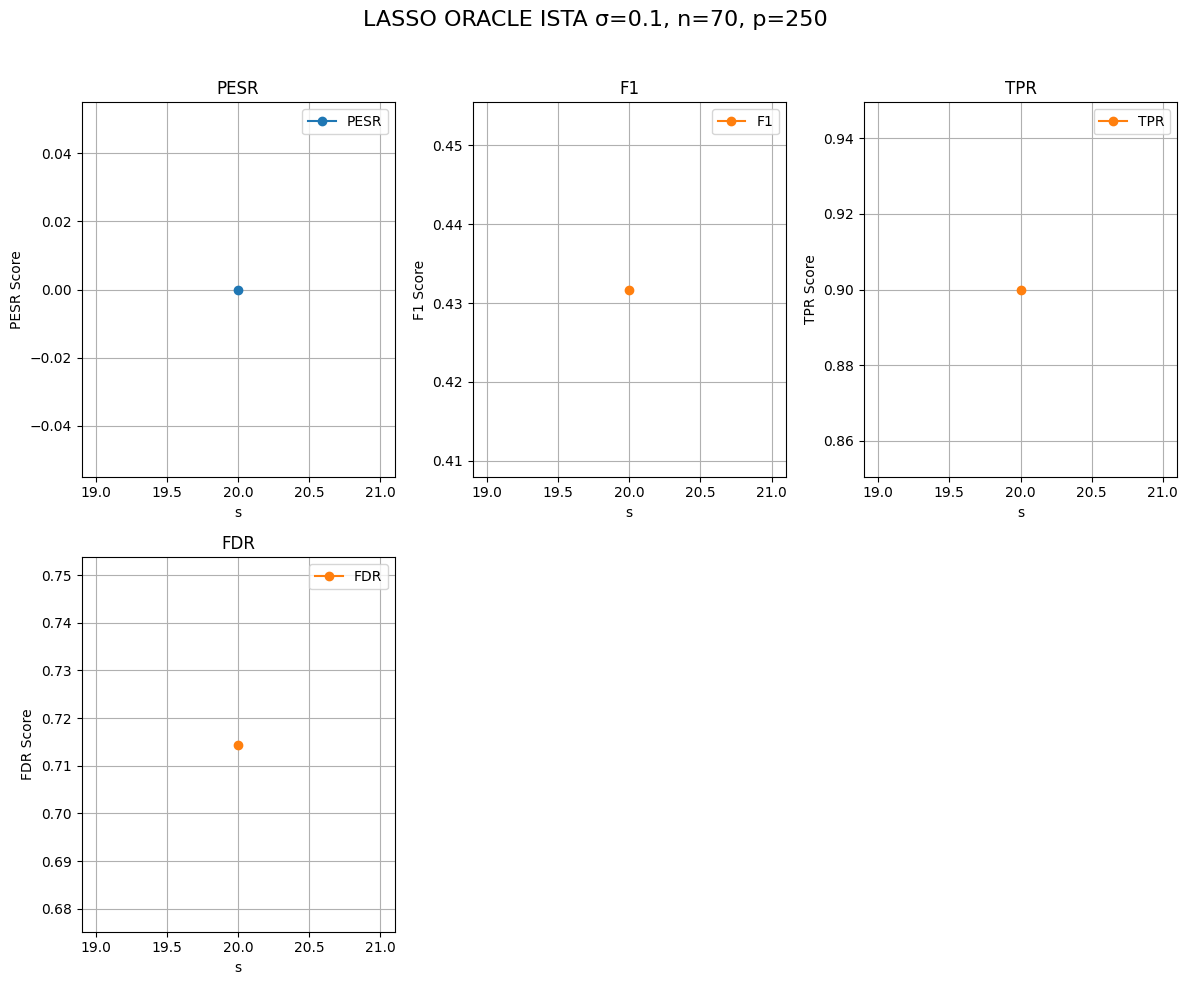

In [10]:
from simulations import SimulationLassoOracleIsta

Sim1 = SimulationLassoOracleIsta(
    n = n,
    p = p,
    list_s = list_s,
    sigma = sigma,
    simu_iter = simu_iter,
    qut_iter = qut_iter,
    max_iter = max_iter,
    tol = tol,
    seed = seed,
    verbose=True
)

Sim1.run()

Sim1.plot()

### LASSO avec ISTA backtracking en ORACLE

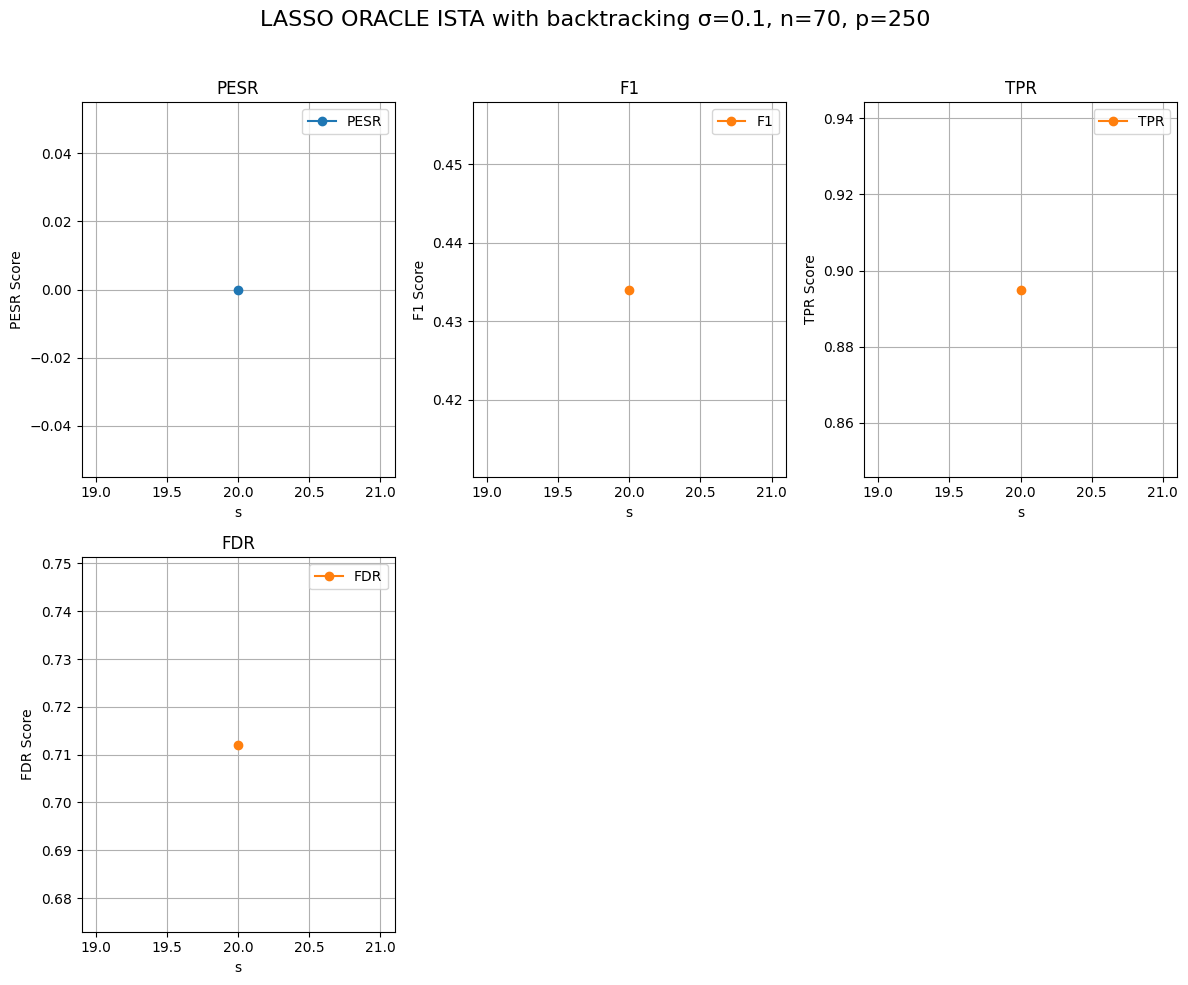

In [11]:
from simulations import SimulationLassoOracleIstaBacktracking

Sim2 = SimulationLassoOracleIstaBacktracking(
    n = n,
    p = p,
    list_s = list_s,
    sigma = sigma,
    simu_iter = simu_iter,
    qut_iter = qut_iter,
    max_iter = max_iter,
    tol = tol,
    seed = seed,
    verbose=False
)

Sim2.run()

Sim2.plot()

### Comparaison des simulations

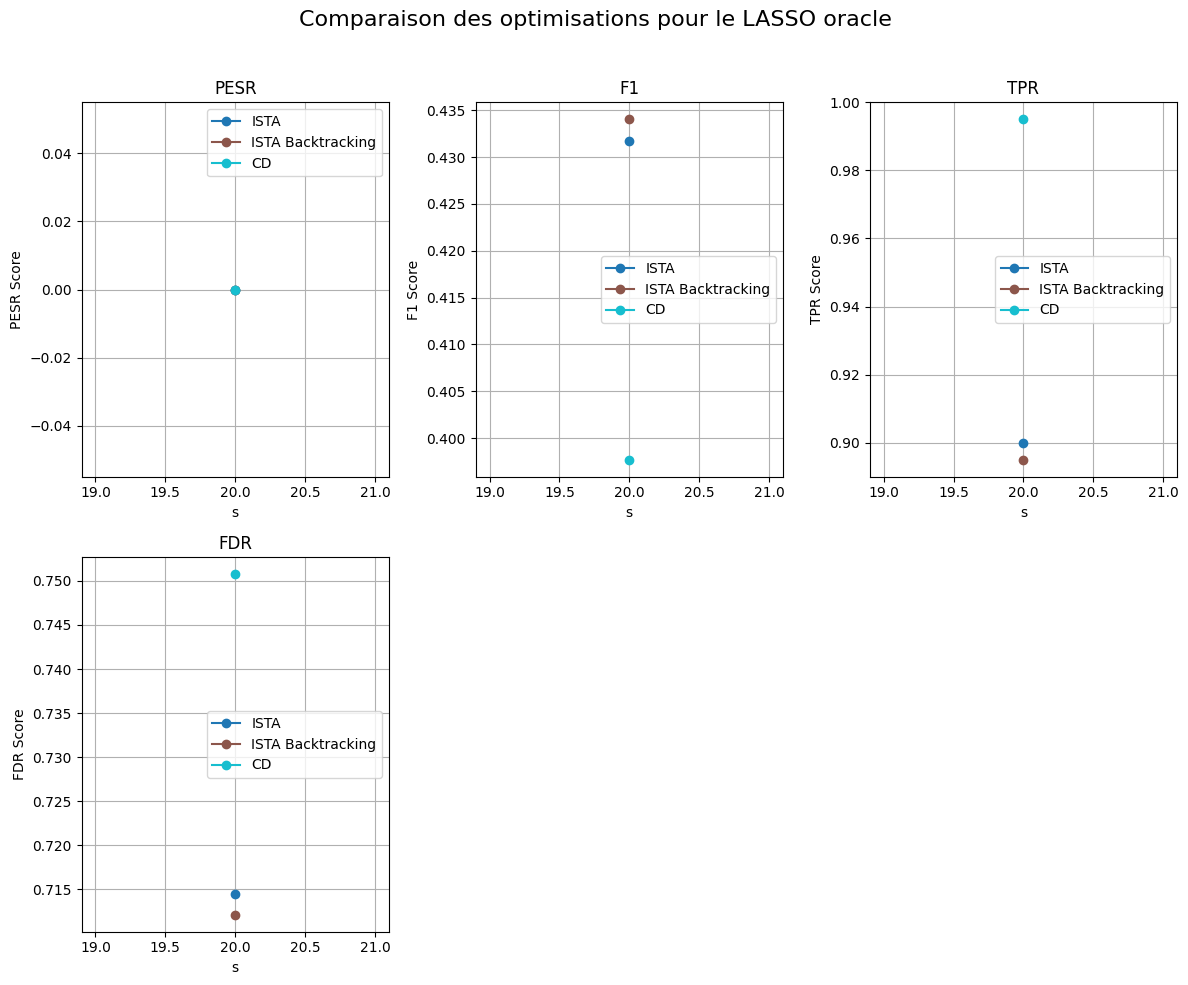

In [12]:
from linear_tools import plot_simulations

simulations = {
    'ISTA': Sim1.score,
    'ISTA Backtracking': Sim2.score,
    'CD': Sim3.score
}

plot_simulations(simulations, Sim1.list_s, "Comparaison des optimisations pour le LASSO oracle")